# Семинар 6. Выбор модели. Кросс-валидация. Отбор признаков

Подключение библиотек. 
$
\newcommand{\R}{\mathbb{R}}
\newcommand{\X}{\mathbb{X}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\E}{\mathbb{E}}
\newcommand{\D}{\mathbb{D}}
\renewcommand{\Prob}{\mathbb{P}}
\renewcommand{\le}{\leqslant}
\renewcommand{\ge}{\geqslant}
\newcommand{\eps}{\varepsilon}
\newcommand{\Normal}{\mathcal{N}}
\DeclareMathOperator{\TP}{TP}
\DeclareMathOperator{\FP}{FP}
\DeclareMathOperator{\TN}{TN}
\DeclareMathOperator{\FN}{FN}
\DeclareMathOperator{\Accuracy}{Accuracy}
\DeclareMathOperator{\Precision}{Precision}
\DeclareMathOperator{\Recall}{Recall}
\DeclareMathOperator{\Fscore}{F_1}
\DeclareMathOperator{\MSE}{MSE}
\DeclareMathOperator{\RMSE}{RMSE}
\DeclareMathOperator{\MAE}{MAE}
\DeclareMathOperator{\MAPE}{MAPE}
\DeclareMathOperator{\Rsqured}{R^2}
$

In [65]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wg

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

RdGn = ListedColormap(['red', 'green'])
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 4)

In [66]:
from sklearn import set_config

set_config(display='diagram')

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def regression_metrics(true, pred, verbose=False, plot=False):
    mae = mean_absolute_error(true, pred)
    mape = np.abs((true - pred) / true).mean()
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)

    if verbose:
        print('MAE: ', mae)
        print('MSE: ', mse)
        print('RMSE:', rmse)
        print('MAPE:', mape)
        print('R2:  ', r2)
        print()
    
    if plot:
        plt.figure(0, (6, 6))
        plt.scatter(true, pred)
        low = min(true.min(), pred.min())
        high = max(true.max(), pred.max())

        plt.plot([low, high], [low, high], color='blue')
        plt.xlabel('Ground Truth')
        plt.ylabel('Prediction')
        plt.show()
        
    return (mae, mse, rmse, mape, r2)

# Задача выбора модели

* __Настройка гиперпараметров:__ для конкретного вида модели выбрать наилучшие гиперпараметры (параметры обучения).
* __Выбор вида модели и алгоритма обучения:__ выбрать один из альтернативных видов модели.
* __Отбор признаков:__ отбросить неинформативные признаки.

# 1. Настройка гиперпараметров

Датасет __mpg__. По характеристикам машины необходимо спрогнозировать расход топлива.

Признаки:
* cylinders -- число цилиндров в двигателе;
* displacement -- рабочий объем, л;
* horsepower -- мощность, л.с.;
* weight -- вес, т;
* acceleration -- ускорение;
* model_year -- год выпуска модели;
* origin -- производитель;
* name -- название.

Целевая переменная:
* mpg -- миль на галлон, переведено в км/л.

In [5]:
frame = sns.load_dataset('mpg')
frame.dropna(inplace=True)

frame['displacement'] *= 16.3871 / 1000
frame['mpg'] = 100 / (frame.mpg * 1.60934 / 3.78541)
frame['weight'] *= 0.453592 / 1000

frame.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,13.067503,8,5.030840,130.0,1.589386,12.0,70,usa,chevrolet chevelle malibu
1,15.681004,8,5.735485,165.0,1.675115,11.5,70,usa,buick skylark 320
2,13.067503,8,5.211098,150.0,1.558542,11.0,70,usa,plymouth satellite
3,14.700941,8,4.981678,150.0,1.557181,12.0,70,usa,amc rebel sst
4,13.836180,8,4.948904,140.0,1.564439,10.5,70,usa,ford torino


Данные к обучению:

In [6]:
X = frame.drop(columns=['mpg', 'name']).copy()
y = frame.mpg.copy()

## 1.1. Метод отложенной выборки

* Делим датасет на 3 части:
    * __Train__ -- используется для обучения параметров модели.
    * __Valid__ -- используется для оценки обобщающей способности модели и для отбора гиперпараметров.
    * __Test__ -- используется для финальной оценки качества алгоритма.

In [7]:
from sklearn.model_selection import train_test_split


X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_fit, y_fit, test_size=0.1, random_state=42)

print('Train size:', X_train.shape[0])
print('Valid size:', X_valid.shape[0])
print('Test size:', X_test.shape[0])

Train size: 281
Valid size: 32
Test size: 79


Преобразование признаков и модель:

In [10]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year']
cat_features = ['origin']

transformer = make_column_transformer((StandardScaler(), num_features), (OneHotEncoder(drop='first'), cat_features))
transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['displacement', 'horsepower', 'weight',
                                  'acceleration', 'cylinders', 'model_year']),
                                ('onehotencoder', OneHotEncoder(drop='first'),
                                 ['origin'])])

In [11]:
from sklearn.linear_model import Ridge


estimator = Ridge(alpha=1e-3)
estimator

Ridge(alpha=0.001)

In [12]:
from sklearn.pipeline import make_pipeline


model = make_pipeline(transformer, estimator)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_valid = model.predict(X_valid)

In [13]:
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('ridge', Ridge(alpha=0.001))])

Печатаем метрики:

Train:
MAE:  1.0065714456298274
MSE:  1.8271676990014456
RMSE: 1.3517276719078608
MAPE: 0.09233814607795612
R2:   0.888276001098649

Valid:
MAE:  0.933371574464639
MSE:  1.5088999890361994
RMSE: 1.2283729030861106
MAPE: 0.09445970413429358
R2:   0.808376611496636



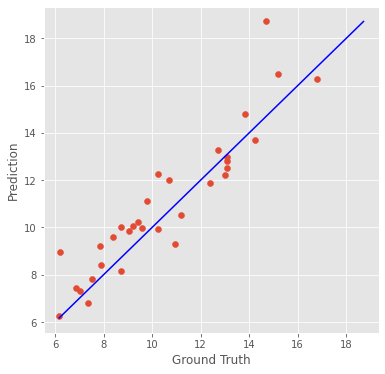

(0.933371574464639,
 1.5088999890361994,
 1.2283729030861106,
 0.09445970413429358,
 0.808376611496636)

In [14]:
print('Train:')
regression_metrics(y_train, pred_train, verbose=True)

print('Valid:')
regression_metrics(y_valid, pred_valid, verbose=True, plot=True)

Выбор гиперпараметров:


Best alpha: 44.22514763163044
Idx of best alpha: 118


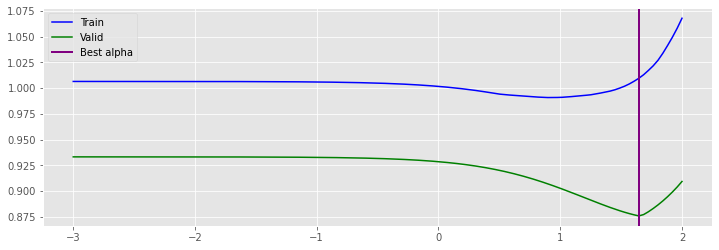

In [15]:
# Best MAE
from tqdm.auto import tqdm


def func(alpha):
    model = make_pipeline(transformer, Ridge(alpha=alpha))
    model.fit(X_train, y_train)
    
    score = mean_absolute_error
    
    metrics_train = score(y_train, model.predict(X_train))
    metrics_valid = score(y_valid, model.predict(X_valid))
    return metrics_train, metrics_valid

alpha_list = np.logspace(-3, 2, 128)
metrics_list = [func(alpha) for alpha in tqdm(alpha_list)]
train_list, valid_list = zip(*metrics_list)

best_idx = np.argmin(valid_list)
alpha_best = alpha_list[best_idx]
print('Best alpha:', alpha_best)
print('Idx of best alpha:', best_idx)

plt.plot(np.log10(alpha_list), train_list, color='blue', label='Train')
plt.plot(np.log10(alpha_list), valid_list, color='green', label='Valid')
plt.axvline(np.log10(alpha_best), color='purple', lw=2, label='Best alpha')
plt.legend()
plt.show()

Обучаем итоговую модель:

In [16]:
estimator = Ridge(alpha=alpha_best)

model = make_pipeline(transformer, estimator)
model.fit(X_fit, y_fit)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('ridge', Ridge(alpha=44.22514763163044))])

Fit:
MAE:  0.9926126530297403
MSE:  1.9492897682964878
RMSE: 1.396169677473511
MAPE: 0.09046292873991105
R2:   0.874638841932597

Test:
MAE:  0.9272767346617419
MSE:  1.6592567207775493
RMSE: 1.2881213920968588
MAPE: 0.08099501762559672
R2:   0.8829842270316925



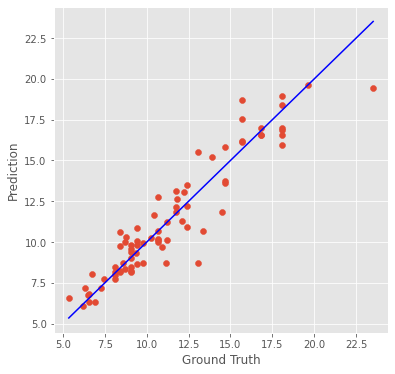

(0.9272767346617419,
 1.6592567207775493,
 1.2881213920968588,
 0.08099501762559672,
 0.8829842270316925)

In [17]:
print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True, plot=True)

## 1.2. Кросс-валидация

Цели:
* Выбор модели.
* Оценка качества.

Основные разновидности кросс-валидации:
* __Leave One Out:__ 
    * по очереди откладываем одно наблюдение для оценки;
    * обучаем на всей выборке кроме выбранного наблюдения;
    * считаем метрики на отложенном наблюдении.
* __K-Fold:__
    * делим на $k$ непересекающихся групп (fold-ов);
    * далее аналогично Leave One Out.
* __Repeated K-Fold:__
    * несколько раз с разными разбиениями повторяется K-Fold.
* __Stratified K-Fold:__
    * Разбиения пропорционально категориальному признаку (распределение по категориям в fold-ах будет похожим).
* __Grouped K-Fold:__
    * Если одному объекту принадлежит несколько наблюдений (например, пользователь померил несколько моделей обуви).

In [18]:
X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Fit size:', X_fit.shape[0])
print('Test size:', X_test.shape[0])

Fit size: 313
Test size: 79


$L_2$-регуляризация с кросс-валидацией:

In [26]:
from sklearn.linear_model import RidgeCV


estimator = RidgeCV(alphas=np.logspace(-3, 2, 64), scoring='neg_mean_squared_error')
model = make_pipeline(transformer, estimator)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00000000e-03, 1.20050806e-03, 1.44121960e-03, 1.73019574e-03,
       2.07711393e-0...
       1.49486913e+00, 1.79460244e+00, 2.15443469e+00, 2.58641621e+00,
       3.10501350e+00, 3.72759372e+00, 4.47500630e+00, 5.37228112e+00,
       6.44946677e+00, 7.74263683e+00, 9.29509790e+00, 1.11588399e+01,
       1

Настраиваем гиперпараметры и смотрим на качество модели:

In [27]:
model.fit(X_fit, y_fit)

print('Best alpha:', model['ridgecv'].alpha_)
print('Coefs:', model['ridgecv'].coef_)

Best alpha: 2.154434690031882
Coefs: [-0.49562088  1.08978765  1.979628    0.23120289  0.58091994 -1.1687093
  0.15679769  0.77167686]


Fit:
MAE:  0.9853606796923264
MSE:  1.793282315748946
RMSE: 1.339134913199169
MAPE: 0.09092546627851082
R2:   0.8846718679283148

Test:
MAE:  0.9718889261142355
MSE:  1.5602084197707857
RMSE: 1.2490830315758779
MAPE: 0.08740506806223337
R2:   0.8899694110350894



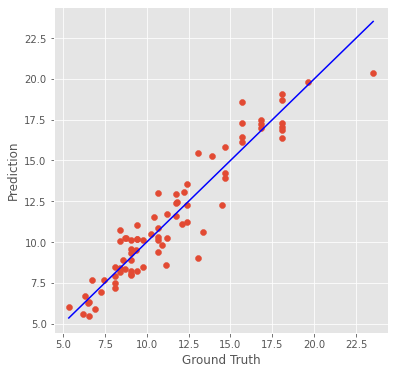

(0.9718889261142355,
 1.5602084197707857,
 1.2490830315758779,
 0.08740506806223337,
 0.8899694110350894)

In [28]:
print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True, plot=True)

# 1.3. GridSearch

Умеет перебирать все возможные гипер-параметры и находить оптимальные для произвольных алгоритмов машинного обучения.

In [31]:
X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_fit, y_fit, test_size=0.1, random_state=42)

print('Train size:', X_train.shape[0])
print('Valid size:', X_valid.shape[0])
print('Test size:', X_test.shape[0])

Train size: 281
Valid size: 32
Test size: 79


In [33]:
from sklearn.model_selection import GridSearchCV


grid_search = GridSearchCV(Ridge(), {
    'alpha': np.logspace(-3, 2, 32),
    'solver': ('svd', 'cholesky', 'lsqr')
})

model = make_pipeline(transformer, grid_search)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('gridsearchcv',
                 GridSearchCV(estimator=Ridge(),
                              param_grid={'alpha': array([1.00000000e-03, 1.44974067e-03, 2....
       1.95129342e-02, 2.82886943e-02, 4.10112707e-02, 5.94557071e-02,
       8.61953566e-02, 1.24960914e-01, 1.81160919e-01, 2.62636353e-01,
       3.80754602e-01, 5.51995432e-01, 8.00250228e-01, 1

In [35]:
model.fit(X_fit, y_fit)
model['gridsearchcv'].best_estimator_

Ridge(alpha=3.5349811050301057, solver='lsqr')

Fit:
MAE:  0.9821045073394921
MSE:  1.7984240145187897
RMSE: 1.341053322772361
MAPE: 0.09053643858843877
R2:   0.8843411991264236

Test:
MAE:  0.9669734130451547
MSE:  1.5631130532786452
RMSE: 1.250245197262779
MAPE: 0.08670568528090154
R2:   0.8897645675465227



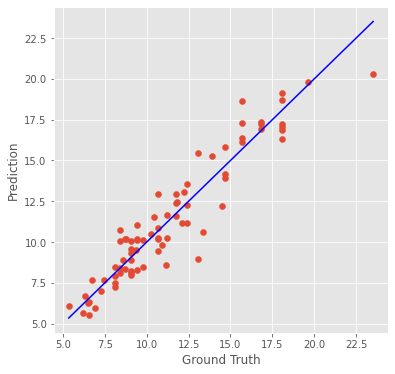

(0.9669734130451547,
 1.5631130532786452,
 1.250245197262779,
 0.08670568528090154,
 0.8897645675465227)

In [36]:
print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True, plot=True)

GridSearch для всего пайплайна:

In [39]:
estimator = Ridge()
pipeline = make_pipeline(transformer, estimator)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('ridge', Ridge())])

In [40]:
pipeline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    ['displacement', 'horsepower', 'weight',
                                     'acceleration', 'cylinders', 'model_year']),
                                   ('onehotencoder', OneHotEncoder(drop='first'),
                                    ['origin'])])),
  ('ridge', Ridge())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  ['displacement', 'horsepower', 'weight',
                                   'acceleration', 'cylinders', 'model_year']),
                                 ('onehotencoder', OneHotEncoder(drop='first'),
                                  ['origin'])]),
 'ridge': Ridge(),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transf

In [42]:
grid_search = GridSearchCV(pipeline, {
    'ridge__alpha': np.logspace(-3, 2, 32),
    'ridge__solver': ('svd', 'cholesky', 'lsqr'),
    'columntransformer__standardscaler__with_mean': (False, True)
})
grid_search.fit(X_fit, y_fit)
grid_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('ridge', Ridge(alpha=3.5349811050301057, solver='cholesky'))])

FINAL GRIDSEARCH METRICS:
MAE:  0.9667811576541921
MSE:  1.5626387355606752
RMSE: 1.2500554929924812
MAPE: 0.08668780203659783
R2:   0.8897980178581627



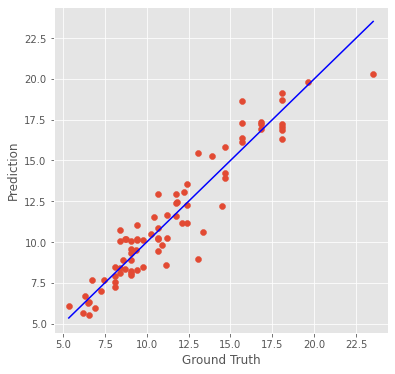

(0.9667811576541921,
 1.5626387355606752,
 1.2500554929924812,
 0.08668780203659783,
 0.8897980178581627)

In [44]:
print('FINAL GRIDSEARCH METRICS:')
regression_metrics(y_test, grid_search.predict(X_test), verbose=True, plot=True)

# 2. Выбор вида модели

__Задача:__ отобрать параметры для метода $k$ ближайших соседей.

In [45]:
# обучить модель на fit и сравнить качество на test

In [46]:
from sklearn.neighbors import KNeighborsRegressor

In [48]:
knn = KNeighborsRegressor(n_neighbors=4, weights='distance', leaf_size=29, p=1)
pipeline = make_pipeline(transformer, knn)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('kneighborsregressor',
                 KNeighborsRegressor(leaf_size=29, n_neighbors=4, p=1,
                                     weights='distance'))])

In [50]:
make_pipeline

In [51]:
transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['displacement', 'horsepower', 'weight',
                                  'acceleration', 'cylinders', 'model_year']),
                                ('onehotencoder', OneHotEncoder(drop='first'),
                                 ['origin'])])

In [49]:
pipeline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    ['displacement', 'horsepower', 'weight',
                                     'acceleration', 'cylinders', 'model_year']),
                                   ('onehotencoder', OneHotEncoder(drop='first'),
                                    ['origin'])])),
  ('kneighborsregressor',
   KNeighborsRegressor(leaf_size=29, n_neighbors=4, p=1, weights='distance'))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  ['displacement', 'horsepower', 'weight',
                                   'acceleration', 'cylinders', 'model_year']),
                                 ('onehotencoder', OneHotEncoder(drop='first'),
                                  ['origin'])]),
 'kneighborsregressor': KNeighborsRegressor(leaf_size=29, n_neighbors=4, p=1, weights

In [64]:
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('kneighborsregressor',
                 KNeighborsRegressor(leaf_size=29, n_neighbors=4, p=1,
                                     weights='distance'))])

In [68]:
grid_search = GridSearchCV(pipeline, {
    'kneighborsregressor__n_neighbors': (1, 2, 4, 6, 8, 10, 15),
    'kneighborsregressor__leaf_size': (10, 20, 30, 40),
    'kneighborsregressor__weights': ('distance', 'uniform'),
    'kneighborsregressor__p': (1, 2, 3, 10)
}, verbose=1, n_jobs=-1)
grid_search.fit(X_fit, y_fit)
grid_search.best_estimator_

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('kneighborsregressor',
                 KNeighborsRegressor(leaf_size=10, n_neighbors=4, p=1,
                                     weights='distance'))])

In [69]:
import sklearn

sklearn.__version__

'0.24.1'

In [70]:
# !pip3 install --user --upgrade scikit-learn

In [73]:
print('FINAL KNN METRICS:')
regression_metrics(y_test, grid_search.predict(X_test), verbose=True)

FINAL KNN METRICS:
MAE:  0.822720457465188
MSE:  1.2513069714640999
RMSE: 1.1186183314536284
MAPE: 0.07230392898775811
R2:   0.9117540699682157



(0.822720457465188,
 1.2513069714640999,
 1.1186183314536284,
 0.07230392898775811,
 0.9117540699682157)

In [74]:
regression_metrics(y_fit, grid_search.predict(X_fit), verbose=True)

MAE:  0.0
MSE:  0.0
RMSE: 0.0
MAPE: 0.0
R2:   1.0



(0.0, 0.0, 0.0, 0.0, 1.0)

__Задача:__ 
* обучить понравившуюся Вам модель и подобрать к ней гиперпараметры;
* выбрать метрику качества и сравнить с KNN.

# 3. Отбор признаков

Sklearn обладает инструментами для отбора признаков ([ссылка на документацию](https://scikit-learn.org/stable/modules/feature_selection.html)).

* Удаление признаков с малой дисперсией.
* Отбор признаков с помощью статистических критериев.
* С помощью $L_1$ регуляризации.
* Рекурсивный отбор признаков.
* Последовательный отбор признаков.

In [85]:
from sklearn.feature_selection import (
    f_regression,
    SelectKBest,
    SelectFromModel,
    RFE,
    SequentialFeatureSelector
)

Выбор с помощью модели:

In [79]:
from sklearn.linear_model import LinearRegression


features = np.random.normal(size=(128, 16))
targets = 0.1 + 0.05 * features[:, 0] + 0.02 * features[:, 2] - 0.1 * features[:, 4] + np.random.normal(scale=1)

In [80]:
selector = SelectFromModel(LinearRegression(), max_features=16)
selector.fit(features, targets)

display(selector.get_support())
selector.transform(features)[:5]

array([ True, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False])

array([[-0.47962266,  1.72931129,  0.32654216],
       [ 0.25732349, -0.69511465, -1.88886454],
       [-0.42097341,  1.02867865,  2.47673055],
       [ 0.74480749,  0.66961826,  0.32600222],
       [-0.77902956, -0.47399566, -0.27826127]])

Рекурсивный отбор признаков:

In [81]:
selector = RFE(LinearRegression(), n_features_to_select=6)
selector.fit(features, targets)

display(selector.get_support())
selector.transform(features)[:5]

array([ True, False,  True, False,  True,  True, False, False,  True,
       False, False,  True, False, False, False, False])

array([[-0.47962266,  1.72931129,  0.32654216,  0.76181532,  0.15270021,
         0.63963188],
       [ 0.25732349, -0.69511465, -1.88886454, -0.8259531 , -0.22795565,
         0.84911401],
       [-0.42097341,  1.02867865,  2.47673055,  0.03764266, -1.74788358,
        -0.06904095],
       [ 0.74480749,  0.66961826,  0.32600222,  0.10423571,  0.88208359,
        -0.07654161],
       [-0.77902956, -0.47399566, -0.27826127, -0.61392238,  0.30981726,
         1.23669561]])

In [84]:
selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=4, direction='backward')
selector.fit(features, targets)

display(selector.get_support())
selector.transform(features)[:5]

array([ True, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False,  True])

array([[-0.47962266,  1.72931129,  0.32654216,  0.71140138],
       [ 0.25732349, -0.69511465, -1.88886454,  0.11285552],
       [-0.42097341,  1.02867865,  2.47673055, -2.37464599],
       [ 0.74480749,  0.66961826,  0.32600222, -0.0898069 ],
       [-0.77902956, -0.47399566, -0.27826127, -0.39845998]])

Встраиваем в Pipeline:

In [86]:
selector = SelectKBest(score_func=f_regression, k=5)
estimator = LinearRegression()

model = make_pipeline(transformer, selector, estimator)
model.fit(X_fit, y_fit)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('selectkbest',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x149220d40>)),
                ('linearregression', LinearRegression())])

Fit:
MAE:  1.0018041818601024
MSE:  1.8812190392068615
RMSE: 1.3715753859000466
MAPE: 0.09219059870465737
R2:   0.879016551992926

Test:
MAE:  0.9380611803107153
MSE:  1.4788264808266876
RMSE: 1.2160700970037408
MAPE: 0.08266362250396748
R2:   0.895708710066972



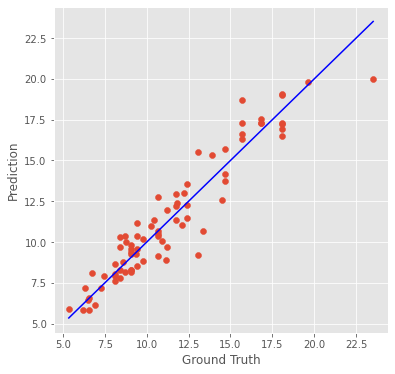

(0.9380611803107153,
 1.4788264808266876,
 1.2160700970037408,
 0.08266362250396748,
 0.895708710066972)

In [87]:
print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True, plot=True)

In [88]:
selector = SelectKBest(score_func=f_regression, k=1)
estimator = Ridge()

pipeline = make_pipeline(transformer, selector, estimator)
pipeline.fit(X_fit, y_fit)

model = GridSearchCV(pipeline, {
    'ridge__alpha': np.logspace(-4, 3, 16),
    'ridge__fit_intercept': [False, True],
    'columntransformer__standardscaler__with_mean': [False, True],
    'selectkbest__k': list(range(1, 9))
}, verbose=1, n_jobs=16)
model.fit(X_fit, y_fit)
model.best_estimator_

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(with_mean=False),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('selectkbest',
                 SelectKBest(k=7,
                             score_func=<function f_regression at 0x149220d40>)),
                ('ridge', Ridge(alpha=4.641588833612782))])

In [89]:
print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True)

Fit:
MAE:  0.9802459043064001
MSE:  1.805649638037951
RMSE: 1.3437446327475884
MAPE: 0.09041156415340186
R2:   0.8838765106296934

Test:
MAE:  0.962844266556017
MSE:  1.5684902616403231
RMSE: 1.2523938125207754
MAPE: 0.0862656821343326
R2:   0.8893853506447774



(0.962844266556017,
 1.5684902616403231,
 1.2523938125207754,
 0.0862656821343326,
 0.8893853506447774)

# 4. Оценка качества модели на кросс-валидации

In [91]:
estimator = Ridge(alpha=0.01)
model = make_pipeline(transformer, estimator)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('ridge', Ridge(alpha=0.01))])

In [92]:
from sklearn.model_selection import KFold


cv = KFold(n_splits=5, shuffle=True, random_state=42)

metrics = []

for fit_index, test_index in cv.split(X, y):
    X_fit = X.iloc[fit_index]
    X_test = X.iloc[test_index]
    
    y_fit = y.iloc[fit_index]
    y_test = y.iloc[test_index]
    
    model.fit(X_fit, y_fit)
    pred_test = model.predict(X_test)
    
    metrics.append(regression_metrics(y_test, pred_test))
    
metrics = pd.DataFrame(metrics, columns=['mae', 'mse', 'rmse', 'mape', 'r2'])
metrics

,mae,mse,rmse,mape,r2
0,0.981373,1.561772,1.249709,0.088764,0.889859
1,0.987270,1.809605,1.345215,0.091567,0.856615
2,1.117476,2.472154,1.572308,0.101970,0.861524
3,1.031640,1.929441,1.389043,0.091670,0.889927
4,0.899956,1.475619,1.214751,0.086569,0.889826


In [93]:
metrics.mean()

mae     1.003543
mse     1.849718
rmse    1.354205
mape    0.092108
r2      0.877550
dtype: float64

Из коробки:

In [94]:
from sklearn.model_selection import cross_val_score


cv_result = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
cv_result

array([-1.5617725 , -1.80960454, -2.47215384, -1.92944142, -1.47561944])

In [95]:
cv_result.mean()

-1.8497183466864513

In [100]:
from sklearn.metrics import jaccard_score

In [101]:
?jaccard_score

In [97]:
from sklearn.metrics import SCORERS

SCORERS

{'explained_variance': make_scorer(explained_variance_score),
 'r2': make_scorer(r2_score),
 'max_error': make_scorer(max_error, greater_is_better=False),
 'neg_median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
 'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
 'neg_mean_absolute_percentage_error': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
 'neg_mean_squared_log_error': make_scorer(mean_squared_log_error, greater_is_better=False),
 'neg_root_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
 'neg_mean_poisson_deviance': make_scorer(mean_poisson_deviance, greater_is_better=False),
 'neg_mean_gamma_deviance': make_scorer(mean_gamma_deviance, greater_is_better=False),
 'accuracy': make_scorer(accuracy_score),
 'top_k_accuracy': make_scorer(top_k_accuracy_score, ne

Несколько метрик:

In [98]:
from sklearn.model_selection import cross_validate


cv_result = cross_validate(model, X, y, cv=cv, 
                           scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'])
cv_result

{'fit_time': array([0.01896811, 0.01050115, 0.00951004, 0.00825691, 0.00915599]),
 'score_time': array([0.00644398, 0.00584602, 0.00520492, 0.00520706, 0.00557494]),
 'test_neg_mean_absolute_error': array([-0.98137253, -0.98726984, -1.11747559, -1.03163999, -0.89995615]),
 'test_neg_mean_squared_error': array([-1.5617725 , -1.80960454, -2.47215384, -1.92944142, -1.47561944]),
 'test_r2': array([0.88985911, 0.85661502, 0.86152436, 0.88992746, 0.88982628])}

In [99]:
{k: np.mean(v) for k, v in cv_result.items()}

{'fit_time': 0.011278438568115234,
 'score_time': 0.0056553840637207035,
 'test_neg_mean_absolute_error': -1.0035428172718521,
 'test_neg_mean_squared_error': -1.8497183466864513,
 'test_r2': 0.8775504450675523}